In [48]:
# for arrays and dataframes
import pandas as pd
import numpy as np

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for simulations
import random
import math

#for statistics
from statistics import mean
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint


In [49]:
# read the data into a dataframe
data = pd.read_csv(r'marketing_AB.csv')
data.head(5)

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing

About Dataset
Marketing A/B testing dataset
Marketing companies want to run successful campaigns, but the market is complex and several options can work. So normally they tun A/B tests, that is a randomized experimentation process wherein two or more versions of a variable (web page, page element, banner, etc.) are shown to different segments of people at the same time to determine which version leaves the maximum impact and drive business metrics.

The companies are interested in answering two questions:

Would the campaign be successful?
If the campaign was successful, how much of that success could be attributed to the ads?
With the second question in mind, we normally do an A/B test. The majority of the people will be exposed to ads (the experimental group). And a small portion of people (the control group) would instead see a Public Service Announcement (PSA) (or nothing) in the exact size and place the ad would normally be.

The idea of the dataset is to analyze the groups, find if the ads were successful, how much the company can make from the ads, and if the difference between the groups is statistically significant.

Data dictionary:

Index: Row index
user id: User ID (unique)
test group: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
converted: If a person bought the product then True, else is False
total ads: Amount of ads seen by person
most ads day: Day that the person saw the biggest amount of ads
most ads hour: Hour of day that the person saw the biggest amount of ads

In [50]:
data.describe()

,Unnamed: 0,user id,total ads,most ads hour
count,588101.000000,5.881010e+05,588101.000000,588101.000000
mean,294050.000000,1.310692e+06,24.820876,14.469061
std,169770.279667,2.022260e+05,43.715181,4.834634
min,0.000000,9.000000e+05,1.000000,0.000000
25%,147025.000000,1.143190e+06,4.000000,11.000000
50%,294050.000000,1.313725e+06,13.000000,14.000000
75%,441075.000000,1.484088e+06,27.000000,18.000000
max,588100.000000,1.654483e+06,2065.000000,23.000000


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [52]:
# convert all columns to int64 for easy use
data['test group'].replace(['ad','psa'],[1,0], inplace = True)
data['converted'].replace([True,False],[1,0], inplace = True)
data['most ads day'].replace(['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],[1,2,3,4,5,6,7], inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   Unnamed: 0     588101 non-null  int64
 1   user id        588101 non-null  int64
 2   test group     588101 non-null  int64
 3   converted      588101 non-null  int64
 4   total ads      588101 non-null  int64
 5   most ads day   588101 non-null  int64
 6   most ads hour  588101 non-null  int64
dtypes: int64(7)
memory usage: 31.4 MB


Exploratory Analysis

<AxesSubplot:xlabel='most ads hour', ylabel='count'>

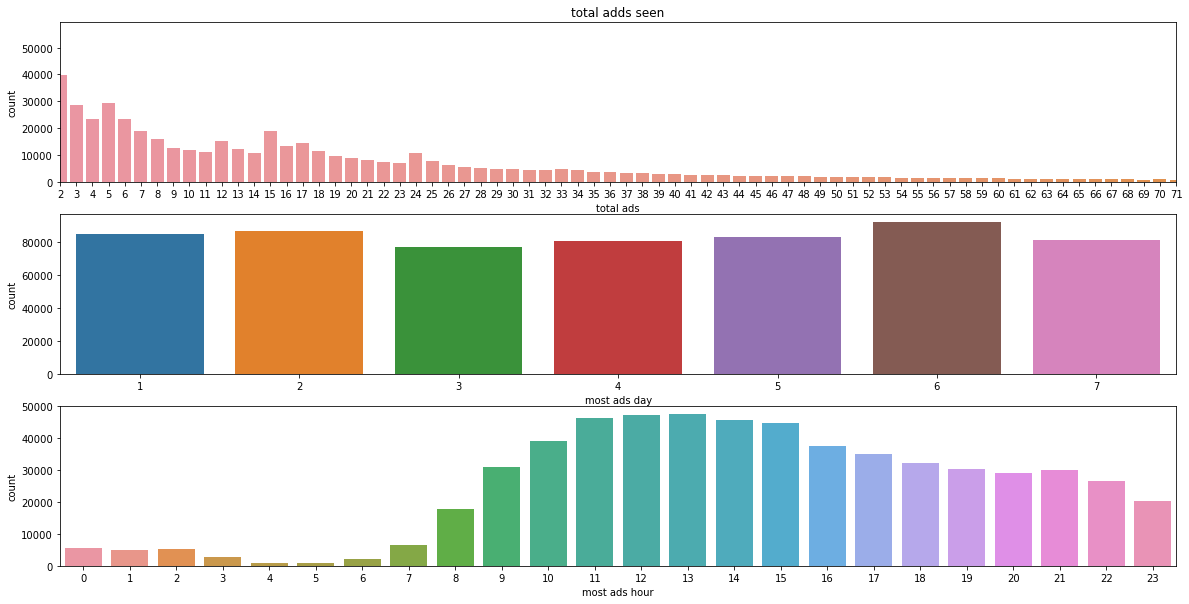

In [53]:
# visualizing distributions of key features in the dataset
fig, ax = plt.subplots(3,1, figsize = (20,10))
sns.countplot(ax = ax[0],x = 'total ads', data = data).set(title='total adds seen')
ax[0].set_xlim(1,70)
sns.countplot(ax = ax[1],x = 'most ads day', data = data)
sns.countplot(ax = ax[2],x = 'most ads hour', data = data)

The number of customers who saw more than 71 adds was: 41296 or approximately 7.02 %


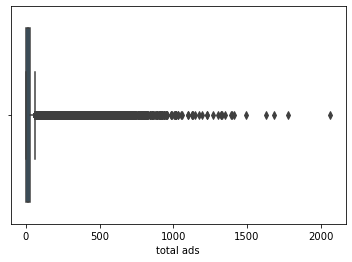

In [54]:
# take a closer look at outliers in number of ads shown
sns.boxplot(data=data, x = 'total ads')
print('The number of customers who saw more than 71 adds was: ' + str(data[data['total ads']>71]['total ads'].count()) + ' or approximately {:0.2f} %'.format(data[data['total ads']>71]['total ads'].count()*100/data['total ads'].count()))

1    564577
0     23524
Name: test group, dtype: int64


([<matplotlib.axis.YTick at 0x1732ce72d30>,
 [Text(0, 0.0, '0%'),
  Text(0, 0.005, '0.5%'),
  Text(0, 0.01, '1.0%'),
  Text(0, 0.015, '1.5%'),
  Text(0, 0.02, '2.0%'),
  Text(0, 0.025, '2.5%')])

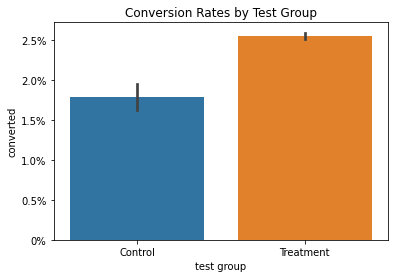

In [55]:
# graph conversion rates for both control and treatment groups
print(data['test group'].value_counts())
sns.barplot(data=data, x = data['test group'], y = data['converted'])
plt.title('Conversion Rates by Test Group')
plt.xticks([0,1],['Control','Treatment'])
plt.yticks([0.000,0.005,0.010,0.015,0.020,0.025],['0%','0.5%','1.0%','1.5%','2.0%','2.5%'])

In [56]:
# numerical values for conversion rates of both control and treatment groups
print(data.groupby('test group')['converted'].mean())

test group
0    0.017854
1    0.025547
Name: converted, dtype: float64


we can see that the conversion rate for those shown adds is 43% higher than those shown psa's 

In [57]:
# were there any duplicate users?
print(data['user id'].duplicated().sum())
# no duplicates were found


0


Frequentist A/B test
-we will use a two tailed test because we dont know how the ads will effect conversion rate
-H_0: Conversion_no_ads = Conversion_with_Ads
-H_a: Conversion_no_ads != Conversion_with_Ads
- set confidence level at 95% -> alpha = 0.05
- set power level at 0.8 by convention
-

In [58]:
# set power level and statistical significance 
alpha = 0.05
power = 0.8

In [59]:
# determine baseline conversion rate. we will say for the sake of this experiment that we took a random sample of 10,000 instances of customers 
# not shown adds to determine our baseline conversion rate
random.seed(42)
control_df = data[data['test group']==0]
converted_list = (control_df['converted']).to_list()
baseline_conversion = mean(random.choices(converted_list,k = 10000))
print('The baseline conversion rate is: ', round(baseline_conversion*100,2), '%')

# determine a standard deviation
means = []
for i in range(10000):
    means.append(mean(random.choices(converted_list,k = 10000)))
baseline_std = np.std(means)
print('The baseline standard deviation is: ', round(baseline_std*100,2), '%')

#calculate minimum observable effect size
min_lift = .33
min_effect_size = (baseline_conversion*(1+min_lift)- baseline_conversion)/baseline_std
MDE = baseline_conversion*(1+min_lift)
print('The minimum detectable effect size is: ',min_effect_size)

The baseline conversion rate is:  1.76 %
The baseline standard deviation is:  0.13 %
The minimum detectable effect size is:  4.46574392435825


In [60]:
# sample size calculation
Z_alpha_half = stats.norm.ppf(1-alpha/2)
print('z/2: ',stats.norm.ppf(1-alpha/2))
Z_beta = stats.norm.ppf(power)
print('z_b: ', Z_beta)

n = round(((Z_alpha_half*math.sqrt(2*baseline_conversion*(1-baseline_conversion))+Z_beta*math.sqrt(baseline_conversion*(1-baseline_conversion)+MDE*(1-MDE)))**2)/(MDE-baseline_conversion)**2)
print('The minimum sample size for this test will be: ', n)

z/2:  1.959963984540054
z_b:  0.8416212335729143
The minimum sample size for this test will be:  8425


since our control group contains 23524 members and our test group is roughly 24x this size we have plenty of observations to conduct this test with the desired accuracy. 

frequentist analysis using only required sample size

In [61]:
# generate simulated samples of minimum size
treatment_results = data[data['test group']==1]['converted']
control_results = data[data['test group']==0]['converted']
random.seed(42)
treatment_results_sim = list(random.sample(list(treatment_results), k = n))
control_results_sim = list(random.sample(list(control_results), k = n))

In [62]:
# calculating z statistic and p-value
n_converted = len(control_results_sim)
n_treatment = len(treatment_results_sim)
successes = [sum(control_results_sim), sum(treatment_results_sim)]
nobs = [n_converted, n_treatment]

z_stat, p_val = proportions_ztest(successes, nobs=nobs, alternative = 'smaller')
(lower_con, lower_treatment), (upper_con, upper_treatment) = proportion_confint(successes, nobs=nobs, alpha=alpha)

print('z statistic: ', -z_stat)
print('p-value: ', p_val)
print('95% confidence interval for control group: ' , format(lower_con,'.3f'), format(upper_con,'.3f'))
print('95% confidence interval for control group: ' , format(lower_treatment,'.3f'), format(upper_treatment,'.3f'))
print('Estimated Lift: ', round(((mean(treatment_results_sim)/mean(control_results_sim))-1)*100,2), '%')

z statistic:  3.4066965601129877
p-value:  0.00032877092548490316
95% confidence interval for control group:  0.014 0.019
95% confidence interval for control group:  0.020 0.027
Estimated Lift:  44.93 %


with a p-value of 0.0007 we were able to determine that there was more than enough evidence to reject to null hypothesis and conclude that the treatment group has conversion rate higher than the control group

fequentist analysis using entire dataset

In [63]:
# calculating z statistic and p-value
n_converted = len(control_results)
n_treatment = len(treatment_results)
successes = [sum(control_results), sum(treatment_results)]
nobs = [n_converted, n_treatment]

z_stat, p_val = proportions_ztest(successes, nobs=nobs, alternative = 'smaller')
(lower_con, lower_treatment), (upper_con, upper_treatment) = proportion_confint(successes, nobs=nobs, alpha=alpha)

print('z statistic: ', -z_stat)
print('p-value: ', p_val)
print('95% confidence interval for control group: ' , format(lower_con,'.3f'), format(upper_con,'.3f'))
print('95% confidence interval for control group: ' , format(lower_treatment,'.3f'), format(upper_treatment,'.3f'))
print('Estimated Lift: ', round(((mean(treatment_results)/mean(control_results))-1)*100,2), '%')


z statistic:  7.3700781265454145
p-value:  8.526403580779863e-14
95% confidence interval for control group:  0.016 0.020
95% confidence interval for control group:  0.025 0.026
Estimated Lift:  43.09 %


and we can see that if we kept collecting data (considered the entire dataset) then the p-value of 8.5e-14 allows us to very safely reject the null hypothesis.

Bayesian A/B test 

In order to conduct a Baysean test we need to establish a prior distribution. Since we do not have very much inform about the company from which this data originates, we will have to do this in a creative way. My choices here are somewhat arbitrary and somewhat based on intuition. my original plas was as follows: Since I assume that as time passes, participants will be exposed to a greater and greater number of adds/psas, I will use the ~ 18% of participants that watched only 1 or 2 psas and use these to construct a prior, I will then use the rest of the data as the experimental set. I found 2 problems with this approach: 1) the mean conversion of this group was only around 0.4% which is much lower than I know the conversion rate to be 2) I did not want to exclude this group from the experimental set because, with such a low mean, excluding this group would skew the results in a consistant way. I have elected to fabricate my own prior distribution to have a mean and variance slightly smaller than the overall set. Although this is not required to do an analysis, I feel that this will give me some useful experience. 

I will use a beta distribution because we have binary results between 0 and 1. So as not to effect out data, I will use low values of alph and beta to reflect low confidence in our initial assumptions. I will use an alpha of 1.8 and a beta of 98.2

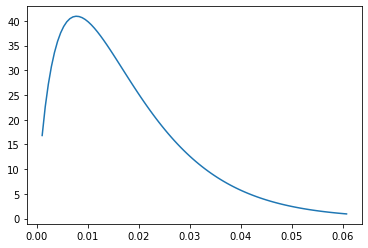

In [64]:
# create and graph a beta distribution to represent our prior assumptions based on the baseline found earlier
prior_alpha = 1.76
prior_beta = 98.24
fig, ax = plt.subplots(1, 1)
x = np.linspace(stats.beta.ppf(0.01, prior_alpha, prior_beta),
                stats.beta.ppf(0.99, prior_alpha, prior_beta), 100)
ax.plot(x, stats.beta.pdf(x, prior_alpha, prior_beta))

results of the test

Probability that treatment results in higher conversion rate:  99.976 %
Probability that treatment results in greater than a 20% lift:  95.885 %
Probability that treatment results in greater than a 33% lift:  79.283 %
The estimated lift is:  44.39 %
There is a 90% probability that the relative lift is between  21.2 % and  72.6 %


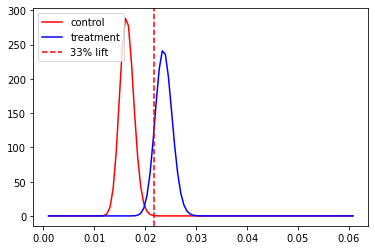

In [84]:
# using minimum sample size
random.seed(42)

# create sample sets of minimum size 
treatment_min = random.sample(list(data[data['test group']==1]['converted']),k = n)
control_min = random.sample(list(data[data['test group']==0]['converted']),k = n)

#calculate number converted and not converted for each group
control_converted = sum(control_min)
treatment_converted = sum(treatment_min)
control_not_convereted = len(control_min) - control_converted
treatment_not_convereted = len(treatment_min) - treatment_converted

# construct posteriors
posterior_control = stats.beta(prior_alpha+control_converted,prior_beta+control_not_convereted)
posterior_treatment = stats.beta(prior_alpha+treatment_converted,prior_beta+treatment_not_convereted)

# generate 100,000 samples of the mean from each group
control_samples = posterior_control.rvs(100000, random_state = 42)
treatment_samples = posterior_treatment.rvs(100000, random_state = 42)

# calculate probabilities and 90% confidence intervals
prob_treatment_better = np.mean(treatment_samples>control_samples)
print('Probability that treatment results in higher conversion rate: ', prob_treatment_better *100, '%')
prob_lift_20 = np.mean(treatment_samples>(control_samples*1.2))
print('Probability that treatment results in greater than a 20% lift: ', round(prob_lift_20*100,3), '%')
prob_lift_33 = np.mean(treatment_samples>(control_samples*1.33))
print('Probability that treatment results in greater than a 33% lift: ', prob_lift_33 *100, '%')
lift = ((treatment_samples/control_samples)-1)*100
lift_lowerbound , lift_upperbound = np.percentile(lift,5), np.percentile(lift,95)
print('The estimated lift is: ',round(((np.mean(treatment_samples)/np.mean(control_samples))-1)*100,2),'%' )
print('There is a 90% probability that the relative lift is between ', round(lift_lowerbound,1), '% and ', round(lift_upperbound,1), '%')

# graph the distributions
fig, ax = plt.subplots(1, 1)
x = np.linspace(stats.beta.ppf(0.01, prior_alpha, prior_beta),
                stats.beta.ppf(0.99, prior_alpha, prior_beta), 100)
ax.plot(x, stats.beta.pdf(x, prior_alpha+control_converted, prior_beta+control_not_convereted),'r-', label = 'control')
ax.plot(x, stats.beta.pdf(x, prior_alpha+treatment_converted, prior_beta+treatment_not_convereted),'b-', label = 'treatment')

# add a vertical line at 33% lift relative to the average control conversion rate
control_mean = np.mean(control_samples)
plt.axvline(x = control_mean*1.33, color = 'r',linestyle = 'dashed', label = '33% lift')

# format the graph
plt.legend(loc = 'upper left')


Probability that treatment results in higher conversion rate:  100.0 %
Probability that treatment results in greater than a 20% lift:  99.982 %
Probability that treatment results in greater than a 33% lift:  96.895 %
The estimated lift is:  47.9 %
There is a 90% probability that the relative lift is between  35.0 % and  62.1 %


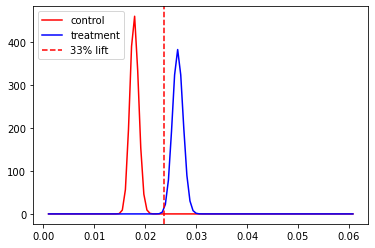

In [92]:
# using even control and treatment sets
random.seed(42)

# create a treatment sample sets of same size as control group
treatment_even = random.sample(list(data[data['test group']==1]['converted']),k = 23524)

#calculate number converted and not converted for each group
control_converted = data[data['test group']==0]['converted'].sum()
treatment_converted = sum(treatment_even)
control_not_convereted = data[data['test group']==0]['converted'].count() - control_converted
treatment_not_convereted = len(treatment_even) - treatment_converted

# construct posteriors
posterior_control = stats.beta(prior_alpha+control_converted,prior_beta+control_not_convereted)
posterior_treatment = stats.beta(prior_alpha+treatment_converted,prior_beta+treatment_not_convereted)

# generate 100,000 samples of the mean from each group
control_samples = posterior_control.rvs(100000, random_state = 42)
treatment_samples = posterior_treatment.rvs(100000, random_state = 42)

# calculate probabilities and 90% confidence intervals
prob_treatment_better = np.mean(treatment_samples>control_samples)
print('Probability that treatment results in higher conversion rate: ', prob_treatment_better *100, '%')
prob_lift_20 = np.mean(treatment_samples>(control_samples*1.2))
print('Probability that treatment results in greater than a 20% lift: ', prob_lift_20 *100, '%')
prob_lift_33 = np.mean(treatment_samples>(control_samples*1.33))
print('Probability that treatment results in greater than a 33% lift: ', prob_lift_33 *100, '%')
lift = ((treatment_samples/control_samples)-1)*100
lift_lowerbound , lift_upperbound = np.percentile(lift,5), np.percentile(lift,95)
print('The estimated lift is: ',round(((np.mean(treatment_samples)/np.mean(control_samples))-1)*100,2),'%' )
print('There is a 90% probability that the relative lift is between ', round(lift_lowerbound,1), '% and ', round(lift_upperbound,1), '%')

# graph the distributions
fig, ax = plt.subplots(1, 1)
x = np.linspace(stats.beta.ppf(0.01, prior_alpha, prior_beta),
                stats.beta.ppf(0.99, prior_alpha, prior_beta), 100)
ax.plot(x, stats.beta.pdf(x, prior_alpha+control_converted, prior_beta+control_not_convereted),'r-', label = 'control')
ax.plot(x, stats.beta.pdf(x, prior_alpha+treatment_converted, prior_beta+treatment_not_convereted),'b-', label = 'treatment')

# add a vertical line at 33% lift relative to the average control conversion rate
control_mean = np.mean(control_samples)
plt.axvline(x = control_mean*1.33, color = 'r',linestyle = 'dashed', label = '33% lift')

# format the graph
plt.legend(loc = 'upper left')

Probability that treatment results in higher conversion rate:  100.0 %
Probability that treatment results in greater than a 20% lift:  99.994 %
Probability that treatment results in greater than a 33% lift:  93.669 %
The estimated lift is:  43.08 %
There is a 90% probability that the relative lift is between  32.2 % and  55.4 %


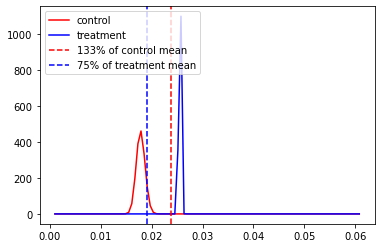

In [86]:
# using entire data set
#calculate number converted and not converted for each group
control_converted = data[data['test group']==0]['converted'].sum()
treatment_converted = data[data['test group']==1]['converted'].sum()
control_not_convereted = data[data['test group']==0]['converted'].count() - control_converted
treatment_not_convereted = data[data['test group']==1]['converted'].count() - treatment_converted

# construct posteriors
posterior_control = stats.beta(prior_alpha+control_converted,prior_beta+control_not_convereted)
posterior_treatment = stats.beta(prior_alpha+treatment_converted,prior_beta+treatment_not_convereted)

# generate 100,000 samples of the mean from each group
control_samples = posterior_control.rvs(100000, random_state = 42)
treatment_samples = posterior_treatment.rvs(100000, random_state = 42)

# calculate probabilities and 90% confidence intervals
prob_treatment_better = np.mean(treatment_samples>control_samples)
print('Probability that treatment results in higher conversion rate: ', prob_treatment_better *100, '%')
prob_lift_20 = np.mean(treatment_samples>(control_samples*1.2))
print('Probability that treatment results in greater than a 20% lift: ', prob_lift_20 *100, '%')
prob_lift_33 = np.mean(treatment_samples>(control_samples*1.33))
print('Probability that treatment results in greater than a 33% lift: ', prob_lift_33 *100, '%')
lift = ((treatment_samples/control_samples)-1)*100
lift_lowerbound , lift_upperbound = np.percentile(lift,5), np.percentile(lift,95)
print('The estimated lift is: ',round(((np.mean(treatment_samples)/np.mean(control_samples))-1)*100,2),'%' )
print('There is a 90% probability that the relative lift is between ', round(lift_lowerbound,1), '% and ', round(lift_upperbound,1), '%')

# graph the distributions
fig, ax = plt.subplots(1, 1)
x = np.linspace(stats.beta.ppf(0.01, prior_alpha, prior_beta),
                stats.beta.ppf(0.99, prior_alpha, prior_beta), 100)
ax.plot(x, stats.beta.pdf(x, prior_alpha+control_converted, prior_beta+control_not_convereted),'r-', label = 'control')
ax.plot(x, stats.beta.pdf(x, prior_alpha+treatment_converted, prior_beta+treatment_not_convereted),'b-', label = 'treatment')

# add a vertical line at 33% lift relative to the average control conversion rate and 75% of average treatment conversion rate
control_mean = np.mean(control_samples)
plt.axvline(x = control_mean*1.33, color = 'r',linestyle = 'dashed', label = '133% of control mean')
treatment_mean = np.mean(treatment_samples)
plt.axvline(x = treatment_mean*.75, color = 'b',linestyle = 'dashed', label = '75% of treatment mean')

#format the graph
plt.legend(loc = 'upper left')

When and how many of these ads should we run?

In [68]:
# find 50th,90th,95th,and 99th percentiles of number of ads or psas seen of users
p_50_raw = np.percentile(data['total ads'],50)
p_90_raw = np.percentile(data['total ads'],90)
p_95_raw = np.percentile(data['total ads'],95)
p_99_raw = np.percentile(data['total ads'],99)
print(p_50_raw,p_90_raw,p_95_raw,p_99_raw)

13.0 57.0 88.0 202.0


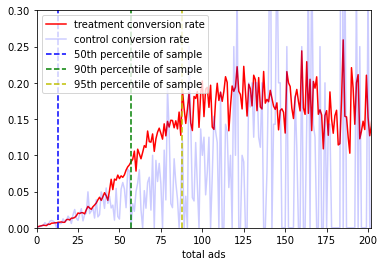

In [98]:
#graph average conversion rate as a function of number of ads seen
num_ads_effect = data[data['test group']==1].groupby('total ads')['converted'].mean()
num_psa_effect = data[data['test group']==0].groupby('total ads')['converted'].mean()
num_ads_effect.plot(c='red', label = 'treatment conversion rate',)
num_psa_effect.plot(c='blue', alpha = 0.2, label = 'control conversion rate')

# add guidelines for sample percentiles
plt.axvline(x = p_50_raw, color = 'b',linestyle = 'dashed', label = '50th percentile of sample')
plt.axvline(x = p_90_raw, color = 'g',linestyle = 'dashed', label = '90th percentile of sample')
plt.axvline(x = p_95_raw, color = 'y',linestyle = 'dashed', label = '95th percentile of sample')

# format graph
plt.legend()
plt.xlim(0,202)
plt.ylim(0,.3)
plt.show()


In [104]:
# create bins for number of ads seen to reduce noise
data['bin']= (data['total ads']/10).apply(np.floor)
p_50 = np.percentile(data['bin'],50)
p_90 = np.percentile(data['bin'],90)
p_95 = np.percentile(data['bin'],95)
p_99 = np.percentile(data['bin'],99)
print(p_50,p_90,p_95, p_99)

1.0 5.0 8.0 20.0


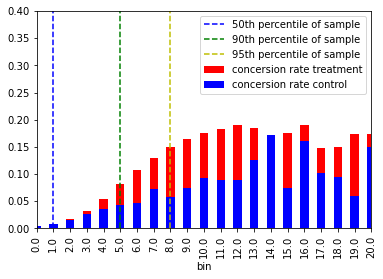

In [107]:
#graph average conversion rate as a function of tens of ads seen
num_ads_effect = data[data['test group']==1].groupby('bin')['converted'].mean()
num_psa_effect = data[data['test group']==0].groupby('bin')['converted'].mean()
num_ads_effect.reset_index()
num_ads_effect.plot.bar(color='red', label = 'concersion rate treatment')
num_psa_effect.plot.bar(color='blue',label = 'concersion rate control')

# add guidelines for sample percentiles
plt.axvline(x = p_50, color = 'b',linestyle = 'dashed', label = '50th percentile of sample')
plt.axvline(x = p_90, color = 'g',linestyle = 'dashed', label = '90th percentile of sample')
plt.axvline(x = p_95, color = 'y',linestyle = 'dashed', label = '95th percentile of sample')

#format graph
plt.xlim(0,20)
plt.ylim(0,.4)
plt.legend()
plt.show()

we can se that showing more adds or seeing more PSAs both result in a higher conversion rate untill you reach about 120 adds or soo before the conversion rate levels off

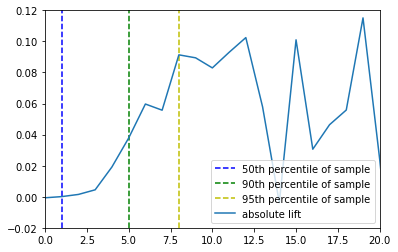

In [108]:
# calculate absolute lift as a function of tens of ads
ads_effect = data[data['test group']==1].groupby('bin', as_index = False)['converted'].mean().rename(columns = {'converted': 'mean conversion adds'})
psa_effect = data[data['test group']==0].groupby('bin', as_index=False)['converted'].mean().rename(columns = {'converted': 'mean conversion psas'})
combined = ads_effect.merge(psa_effect, on='bin')
combined['absolute lift']=(combined['mean conversion adds']-combined['mean conversion psas'])

# add guidelines for sample percentiles
plt.axvline(x = p_50, color = 'b',linestyle = 'dashed', label = '50th percentile of sample')
plt.axvline(x = p_90, color = 'g',linestyle = 'dashed', label = '90th percentile of sample')
plt.axvline(x = p_95, color = 'y',linestyle = 'dashed', label = '95th percentile of sample')

#format graph of absolute lift
plt.plot(combined['bin'],combined['absolute lift'], label = 'absolute lift')
plt.legend()
plt.xlim(0,20)
plt.ylim(-.02,.12)
plt.show()



in examining the lift, we can see that more adds translates to a greater lift relative to PSAs untill you reach 120 adds or so beyond which a lack of data yields noisy results

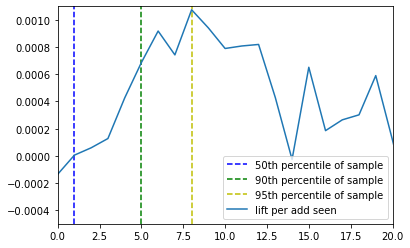

In [109]:
# calculate absolute lift per ad 
combined['lift per add']=(combined['mean conversion adds']-combined['mean conversion psas'])/((combined['bin']*10)+5)

# add guidelines for sample percentiles
plt.axvline(x = p_50, color = 'b',linestyle = 'dashed', label = '50th percentile of sample')
plt.axvline(x = p_90, color = 'g',linestyle = 'dashed', label = '90th percentile of sample')
plt.axvline(x = p_95, color = 'y',linestyle = 'dashed', label = '95th percentile of sample')

# format graph
plt.plot(combined['bin'],combined['lift per add'], label = 'lift per add seen')
plt.legend()
plt.xlim(0,20)
plt.ylim(-.0005,.0011)
plt.show()

once we look at the lift per add shown, however, we can see a maximum around 80 adds beyond which we see a decrease to 0

When should you run these adds?

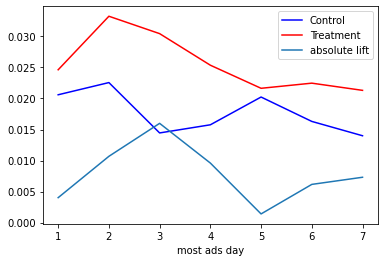

In [75]:
# find mean conversion rates by day ads seen
add_by_day = data[data['test group']==1].groupby('most ads day')['converted'].mean()
psa_by_day = data[data['test group']==0].groupby('most ads day')['converted'].mean()

# plot the conversion rates as a function of day
psa_by_day.plot(color = 'blue', label = 'Control')
add_by_day.plot(color = 'red', label = 'Treatment')

# find and plot absolute lift by day ads seen
lift_by_day = add_by_day.to_frame().merge(psa_by_day, on = 'most ads day')
lift_by_day['absolute lift'] = lift_by_day['converted_x']-lift_by_day['converted_y']
lift_by_day['absolute lift'].plot()

#format graph
plt.legend()


We can see that when the most adds are seen on Monday or Tuesday we get the highest conversion rate and that the adds result in the greatest lift on Monday through Wednesday

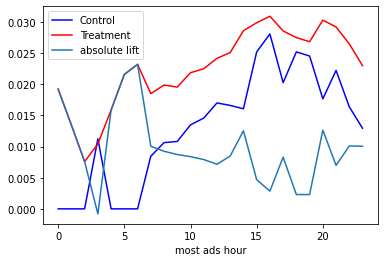

In [76]:
# find mean conversion rates by time of day ads seen
add_by_hour = data[data['test group']==1].groupby('most ads hour')['converted'].mean()
psa_by_hour = data[data['test group']==0].groupby('most ads hour')['converted'].mean()

# plot the conversion rates as a function of time of day
psa_by_hour.plot(color = 'blue', label = 'Control')
add_by_hour.plot(color = 'red', label = 'Treatment')

# find and plot absolute lift by day ads seen
lift_by_hour = add_by_hour.to_frame().merge(psa_by_hour, on = 'most ads hour')
lift_by_hour['absolute lift'] = lift_by_hour['converted_x']-lift_by_hour['converted_y']
lift_by_hour['absolute lift'].plot()

# format graph
plt.legend()

We can see that the greatest absolute lift occured between midnight and 6am. However, only about 7% of our dataset contains information about this time period and that the conversion rate for people only shown PSA's is essentially 0. We are not be able to conclude that these results are significant due to insufficient data. Beyond 6am, the lift achieved was relatively consistent leading to the conclusion that the time of day that the ads are shown is not a significant contributing factor to our desired outcome. 